In [2]:
import tensorflow as tf

In [3]:
import sys
print(sys.executable)
print("\n".join(sys.path))

E:\Xai_Req_Setup\Python3109\python.exe
E:\Xai_Req_Setup\Python3109\python310.zip
E:\Xai_Req_Setup\Python3109

E:\Xai_Req_Setup\Python3109\lib\site-packages
E:\Xai_Req_Setup\Python3109\lib\site-packages\win32
E:\Xai_Req_Setup\Python3109\lib\site-packages\win32\lib
E:\Xai_Req_Setup\Python3109\lib\site-packages\Pythonwin


In [16]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPooling2D,Dense,Conv2D,Input,Flatten
from tensorflow.keras.models import Model
import numpy as np
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt

In [17]:
def build_cnn():
    inputs=Input(shape=(64,64,3))
    x=Conv2D(16,(3,3),activation='relu')(inputs)
    x=MaxPooling2D()(x)
    x=Conv2D(32,(3,3),activation='relu',name='target_layer')(x)
    x=MaxPooling2D()(x)
    x=Flatten()(x)
    x=Dense(32,activation='relu')(x)
    outputs=Dense(10,activation='softmax')(x)
    return Model(inputs,outputs)

model=build_cnn()
intermediate_model=Model(inputs=model.input,outputs=model.get_layer('target_layer').output)

In [18]:
import os
from tensorflow.keras.preprocessing.image import load_img,img_to_array
def load_images(folder):
    images=[]
    for i in os.listdir(folder):
        img_path=os.path.join(folder,i)
        #(64,64) as target_size and same need to provide at CNN input size
        img=load_img(img_path,target_size=(64,64))
        img=img_to_array(img)/255.0
        #img=np.expand_dims(img,axis=0)
        images.append(img)
    return np.array(images)

con_imgs=load_images('tcav_data/Concept_Images')
rand_imgs=load_images('tcav_data/Random_Images')

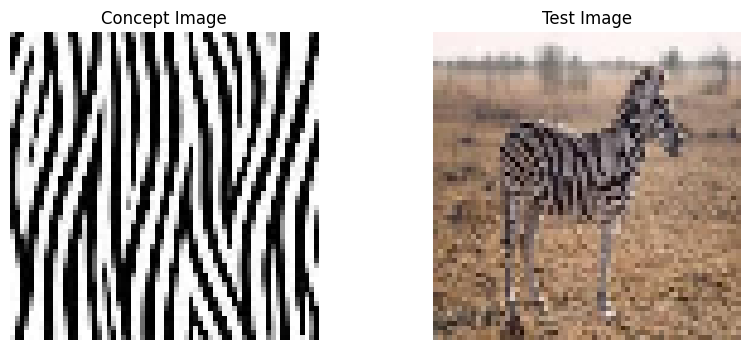

In [70]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.imshow(con_imgs[0])
plt.title("Concept Image")
plt.axis('off')

plt.subplot(122)
sample_image = con_imgs[4]  # test image which is saved test.jpeg in concept images folder
plt.imshow(sample_image)
plt.title("Test Image")
plt.axis('off')
plt.show()

In [71]:
activations_concept = intermediate_model.predict(con_imgs)
activations_random = intermediate_model.predict(rand_imgs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


In [76]:
# Flatten each sample
X = np.vstack([
    activations_concept.reshape(activations_concept.shape[0], -1),
    activations_random.reshape(activations_random.shape[0], -1)
])
y = np.array([1] * len(activations_concept) + [0] * len(activations_random))

cav = SGDClassifier().fit(X, y).coef_
# Directional derivative on sample image
sample_act = intermediate_model.predict(np.expand_dims(con_imgs[3],axis=0)).reshape(-1)
directional_derivative = np.dot(sample_act, cav.T)[0]

# TCAV score
tcav_score = (np.dot(
    activations_concept.reshape(activations_concept.shape[0], -1), cav.T
) > 0).mean()

print(f"Directional Derivative: {directional_derivative:.4f}")
print(f"TCAV Score: {tcav_score}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Directional Derivative: -673.7744
TCAV Score: 0.8


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.linear_model import SGDClassifier

concept_texts = [
    "The match was thrilling and went into overtime.",
    "He scored the winning goal in the final seconds.",
    "The team celebrated their hard-fought victory."
]

random_texts = [
    "She made a delicious cake for her friend's birthday.",
    "I enjoy long walks in the evening.",
    "The weather today is sunny and warm."
]

sample_text = ["The weather today is sunny and warm."]
# 2. Tokenization and padding
all_texts = concept_texts + random_texts + sample_text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_texts)

max_len = 15
def preprocess(texts):
    seqs = tokenizer.texts_to_sequences(texts)
    return pad_sequences(seqs, maxlen=max_len)

X_concept = preprocess(concept_texts)
X_random = preprocess(random_texts)
X_sample = preprocess([sample_text])

vocab_size = len(tokenizer.word_index) + 1

# 3. Model with intermediate output from LSTM
def build_text_model():
    inputs = Input(shape=(max_len,))
    x = Embedding(input_dim=vocab_size, output_dim=16, input_length=max_len)(inputs)
    x = LSTM(32, name="target_layer", return_sequences=False)(x)
    outputs = Dense(2, activation='softmax')(x)
    return Model(inputs, outputs)

model = build_text_model()
inter_model = Model(inputs=model.input, outputs=model.get_layer("target_layer").output)

# 4. Get LSTM activations
act_concept = inter_model.predict(X_concept)
act_random = inter_model.predict(X_random)

# 5. Train linear classifier (CAV)
X_cav = np.vstack([act_concept, act_random])
y_cav = np.array([1]*len(act_concept) + [0]*len(act_random))

cav = SGDClassifier().fit(X_cav, y_cav).coef_.reshape(-1)

# 6. Directional derivative for sample
sample_act = inter_model.predict(X_sample).reshape(-1)
directional_derivative = np.dot(sample_act, cav)

# 7. TCAV score: how many concept activations point in cav direction
tcav_score = (np.dot(act_concept, cav) > 0).mean()

print(f"Directional Derivative: {directional_derivative:.4f}")
print(f"TCAV Score: {tcav_score:.2f}")


E:\Xai_Req_Setup\Python3109\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
Directional Derivative: -0.0259
TCAV Score: 0.67


TCAV TEXT DATA

In [19]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
concept_texts = [
    "The match was thrilling and went into overtime.",
    "He scored the winning goal in the final seconds.",
    "The team celebrated their hard-fought victory."
]

random_texts = [
    "She made a delicious cake for her friend's birthday.",
    "I enjoy long walks in the evening.",
    "The weather today is sunny and warm."
]

sample_text = ["The football player scored a goal."]

In [21]:
all_texts=concept_texts+random_texts+sample_text
tfidf=TfidfVectorizer()
tfidf.fit(all_texts)

TfidfVectorizer()

In [22]:
X_concept=tfidf.transform(concept_texts).toarray()
X_random=tfidf.transform(random_texts).toarray()
X_sample=tfidf.transform(sample_text).toarray()


In [23]:
X_all=np.vstack([X_concept,X_random])
y_all=np.array([1]*len(X_concept)+[0]*len(X_random))

In [24]:
clf=RandomForestClassifier()
clf.fit(X_all,y_all)

RandomForestClassifier()

In [36]:
cav_model=SGDClassifier()
cav_model.fit(X_all,y_all)
cav = cav_model.coef_

sample_pred=clf.predict(X_sample)[0]
directional_derivative=np.dot(sample_pred,cav.T)[0]
print(directional_derivative)

tcav_score=((np.dot(X_concept,cav.T))>0).mean()
print(tcav_score)

[-0.24353178]
1.0


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Input,Flatten
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing.image import load_img,img_to_array

In [2]:
import os
import numpy as np
images=[]
def load_images(folder):
    for i in os.listdir(folder):
        img_path=os.path.join(folder,i)
        image=load_img(img_path,target_size=(150,150))
        img_arr=img_to_array(image)/255.0
        images.append(img_arr)
    return np.array(images)

random_images=load_images('tcav_data/Random_images')
concept_images=load_images('tcav_data/Concept_Images')

In [3]:
def build_cnn():
    inputs=Input(shape=(150,150,3))
    x=Conv2D(32,(3,3),activation='relu')(inputs)
    x=MaxPooling2D()(x)
    x=Conv2D(32,(3,3),activation='relu',name='target_layer')(x)
    x=MaxPooling2D()(x)
    x=Flatten()(x)
    x=Dense(64,activation='relu')(x)
    outputs=Dense(2,activation='sigmoid')(x)
    return Model(inputs,outputs)

model=build_cnn()
inter_model=Model(inputs=model.input,outputs=model.get_layer('target_layer').output)

In [4]:
concept_act=inter_model.predict(concept_images)
random_act=inter_model.predict(random_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


In [18]:
from sklearn.linear_model import SGDClassifier

X=np.vstack([
    concept_act.reshape(concept_act.shape[0],-1),
    random_act.reshape(random_act.shape[0],-1)
])
y=np.array([1]*len(concept_act)+[0]*len(random_act))
clf=SGDClassifier().fit(X,y)

cav=clf.coef_

sample_act=inter_model.predict(np.expand_dims(concept_images[3],axis=0)).reshape(-1)

directional_derivative=np.dot(sample_act,cav.T)[0]
print(f'Directional Derivative {directional_derivative}')

tcav_score=((np.dot(concept_act.reshape(concept_act.shape[0],-1),cav.T))>0).mean()
print(tcav_score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Directional Derivative 16917.373046875
1.0


In [26]:
sample_act.shape

(165888,)